In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import datetime
import yfinance as yf


In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from torch_geometric_temporal.signal import temporal_signal_split

C:\Users\akhan147\Anaconda3\envs\trader\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from pathlib import Path
data_dir = Path(r'F:\cc_data')
model_dir = data_dir.absolute() / 'models'

In [4]:
# GPU support
DEVICE = torch.device('cpu') # cuda
shuffle=True
batch_size = 32

# Data

In [5]:
start = datetime.datetime(2020, 1, 1)
end_train = datetime.datetime(2024, 4, 1)
end_test = datetime.datetime.now()


|Rank	| Symbol |	Fund | Name |
|---|---|----|----|
|1	| SPY	| SPDR S&P 500 ETF Trust |
|2	| IVV	| iShares Core S&P 500 ETF |
|3	| VOO	| Vanguard S&P 500 ETF|
|4	| VTI	| Vanguard Total Stock Market ETF|
|5	| QQQ	| Invesco QQQ Trust Series I|
|6	| VEA	| Vanguard FTSE Developed Markets ETF|
|7	| VUG	| Vanguard Growth ETF|
|8	| VTV	| Vanguard Value ETF|
|9	| IEFA	| iShares Core MSCI EAFE ETF|
|10	| AGG	| iShares Core U.S. Aggregate Bond ETF

[Top ETFs](https://www.marketwatch.com/tools/top-25-etfs)

In [6]:
import yfinance as yf

tickers = ["SPY", "IVV", "VOO", "VTI", "QQQ", "VEA", "VUG", "VTV", "IEFA", "AGG"]

df_train = yf.download(tickers, start=start, end=end_train)
df_test = yf.download(tickers, start=end_train, end=end_test)
df_train.head()

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed


Price                      Adj Close                                     \
Ticker                           AGG       IEFA         IVV         QQQ   
Date                                                                      
2020-01-02 00:00:00+00:00  99.489647  57.861580  302.929291  209.976059   
2020-01-03 00:00:00+00:00  99.781021  57.141933  300.599182  208.052734   
2020-01-06 00:00:00+00:00  99.701538  57.343781  301.787415  209.393250   
2020-01-07 00:00:00+00:00  99.595589  57.212143  300.961212  209.364120   
2020-01-08 00:00:00+00:00  99.480766  57.343781  302.492920  210.937775   

Price                                                                     \
Ticker                            SPY        VEA         VOO         VTI   
Date                                                                       
2020-01-02 00:00:00+00:00  302.208649  38.784161  276.999176  153.396133   
2020-01-03 00:00:00+00:00  299.920227  38.312683  274.975739  152.419861   
2020-01-06 00:00:00+00:00  301.064423  38.443642  276.006073  152.940552   
2020-01-07 00:00:00+00:00  300.217926  38.382526  275.244812  152.577927   
2020-01-08 00:00:00+00:00  301.817993  38.434910  276.665070  153.331100   

Price                                              ...   Volume            \
Ticker                            VTV         VUG  ...      AGG      IEFA   
Date                                               ...                      
2020-01-02 00:00:00+00:00  106.480392  179.231491  ...  6791400  10523100   
2020-01-03 00:00:00+00:00  105.631668  177.999725  ...  3664300   9663700   
2020-01-06 00:00:00+00:00  105.764282  179.144196  ...  8131600   7468300   
2020-01-07 00:00:00+00:00  105.357582  179.086029  ...  2883000   5815100   
2020-01-08 00:00:00+00:00  105.605133  180.492386  ...  7323100   8249700   

Price                                                                     \
Ticker                         IVV       QQQ       SPY      VEA      VOO   
Date                                                                       
2020-01-02 00:00:00+00:00  4070500  30969400  59151200  8229000  3142400   
2020-01-03 00:00:00+00:00  4290400  27518900  77709700  9697300  3247900   
2020-01-06 00:00:00+00:00  4212000  21655300  55653900  8579400  2777100   
2020-01-07 00:00:00+00:00  3632500  22139300  40496400  7884600  2251800   
2020-01-08 00:00:00+00:00  3912100  26397300  68296000  9948100  3719500   

Price                                                 
Ticker                         VTI      VTV      VUG  
Date                                                  
2020-01-02 00:00:00+00:00  3291100  1634700  1035800  
2020-01-03 00:00:00+00:00  3625400  1401600   909800  
2020-01-06 00:00:00+00:00  6813800  1546300   773700  
2020-01-07 00:00:00+00:00  2498400  1422200   848800  
2020-01-08 00:00:00+00:00  4244800  1401700   667200  

[5 rows x 60 columns]

In [8]:
import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()

scaled_train_data = scaler.fit_transform(df_train)
scaled_test_data = scaler.transform(df_test)

joblib.dump(scaler, model_dir / 'scaler.pkl')

['F:\\cc_data\\models\\scaler.pkl']

In [10]:
df_train = pd.DataFrame(scaled_train_data, index=df_train.index, columns= df_train.columns)
df_test = pd.DataFrame(scaled_test_data, index=df_test.index, columns= df_test.columns)
df_train.shape, df_test.shape

((1067, 60), (128, 60))

In [11]:
df_train.head()

Price                     Adj Close                                          \
Ticker                          AGG      IEFA       IVV       QQQ       SPY   
Date                                                                          
2020-01-02 00:00:00+00:00  0.078595 -0.502013 -1.434127 -1.821196 -1.435895   
2020-01-03 00:00:00+00:00  0.127966 -0.605562 -1.473383 -1.854182 -1.474698   
2020-01-06 00:00:00+00:00  0.114498 -0.576518 -1.453365 -1.831192 -1.455297   
2020-01-07 00:00:00+00:00  0.096546 -0.595459 -1.467284 -1.831691 -1.469650   
2020-01-08 00:00:00+00:00  0.077090 -0.576518 -1.441479 -1.804703 -1.442519   

Price                                                                        \
Ticker                          VEA       VOO       VTI       VTV       VUG   
Date                                                                          
2020-01-02 00:00:00+00:00 -0.616525 -1.435764 -1.441905 -0.947610 -1.711986   
2020-01-03 00:00:00+00:00 -0.714247 -1.473018 -1.475328 -0.994208 -1.740928   
2020-01-06 00:00:00+00:00 -0.687103 -1.454049 -1.457502 -0.986927 -1.714037   
2020-01-07 00:00:00+00:00 -0.699771 -1.468065 -1.469916 -1.009256 -1.715403   
2020-01-08 00:00:00+00:00 -0.688913 -1.441916 -1.444131 -0.995665 -1.682359   

Price                      ...    Volume                                \
Ticker                     ...       AGG      IEFA       IVV       QQQ   
Date                       ...                                           
2020-01-02 00:00:00+00:00  ... -0.165613 -0.031850 -0.403814 -0.940624   
2020-01-03 00:00:00+00:00  ... -1.218044 -0.165705 -0.323507 -1.093035   
2020-01-06 00:00:00+00:00  ...  0.285435 -0.507647 -0.352139 -1.352033   
2020-01-07 00:00:00+00:00  ... -1.480993 -0.765139 -0.563770 -1.330655   
2020-01-08 00:00:00+00:00  ...  0.013332 -0.385941 -0.461661 -1.142576   

Price                                                                        \
Ticker                          SPY       VEA       VOO       VTI       VTV   
Date                                                                          
2020-01-02 00:00:00+00:00 -0.658449 -0.603358 -0.624026 -0.329823 -0.882999   
2020-01-03 00:00:00+00:00 -0.219528 -0.431776 -0.583297 -0.173955 -1.077259   
2020-01-06 00:00:00+00:00 -0.741162 -0.562411 -0.765055  1.312639 -0.956669   
2020-01-07 00:00:00+00:00 -1.099646 -0.643603 -0.967855 -0.699420 -1.060091   
2020-01-08 00:00:00+00:00 -0.442168 -0.402468 -0.401229  0.114841 -1.077175   

Price                                
Ticker                          VUG  
Date                                 
2020-01-02 00:00:00+00:00 -0.051753  
2020-01-03 00:00:00+00:00 -0.282331  
2020-01-06 00:00:00+00:00 -0.531391  
2020-01-07 00:00:00+00:00 -0.393960  
2020-01-08 00:00:00+00:00 -0.726284  

[5 rows x 60 columns]

* `1194` : trading days
* (1194, 60) --> (1194, 10, 6, 15) 
* 1194 : num_samples,
* 10 : etfs,
* 6 : OHLC, Add CLose, Volume,
* 15 : bicket size (days), for time being only 1

In [12]:
df_train.index.min(), df_train.index.max()

(Timestamp('2020-01-02 00:00:00+0000', tz='UTC'),
 Timestamp('2024-03-28 00:00:00+0000', tz='UTC'))

In [13]:
df_test.index.min(), df_test.index.max()

(Timestamp('2024-04-01 00:00:00+0000', tz='UTC'),
 Timestamp('2024-10-01 00:00:00+0000', tz='UTC'))

In [14]:
# df.columns

In [15]:
df_train.to_csv(data_dir / 'top10_etf_train.csv')
df_test.to_csv(data_dir / 'top10_etf_test.csv')

In [16]:
data_numpy_test = df_test.values
data_numpy_test.shape

(128, 60)

In [17]:
data_numpy = df_train.values
data_numpy.shape

(1067, 60)

In [19]:
arrays = {}
arrays_test = {}
for level in df_train.columns.levels[1]:
    arrays[level] = df_train.xs(level, axis=1, level=1).to_numpy()
    arrays_test[level] = df_test.xs(level, axis=1, level=1).to_numpy()

In [20]:
arrays.keys()

dict_keys(['AGG', 'IEFA', 'IVV', 'QQQ', 'SPY', 'VEA', 'VOO', 'VTI', 'VTV', 'VUG'])

In [21]:
arrays['AGG'].shape

(1067, 6)

# Tabular data --> Temporal Graph data

In [22]:
num_timesteps_in = 15
num_timesteps_out = 15

In [23]:
indices = [(i, i + num_timesteps_in + num_timesteps_out) for i in range(data_numpy.shape[0] - num_timesteps_in - num_timesteps_out + 1)]
len(indices)

1038

In [24]:
indices[:5]

[(0, 30), (1, 31), (2, 32), (3, 33), (4, 34)]

In [25]:
indices[-5:]

[(1033, 1063), (1034, 1064), (1035, 1065), (1036, 1066), (1037, 1067)]

In [27]:
features = []
targets = []
for i, j in indices:
    
    features_bucket_list = []
    target_bucket_list = []
    
    for etf in arrays.keys():
        features_bucket_list.append(arrays[etf][i : i+num_timesteps_in, :].T)
        target_bucket_list.append(arrays[etf][i+num_timesteps_in : j, 0].T)
    
    features_array_stack = np.stack(features_bucket_list, axis=0)
    target_array_stack = np.stack(target_bucket_list, axis=0)
    
    features.append(features_array_stack)
    targets.append(target_array_stack)

train_input = np.stack(features, axis=0)
train_target = np.stack(targets, axis=0)

train_input.shape, train_target.shape

((1038, 10, 6, 15), (1038, 10, 15))

In [28]:
indices = [(i, i + num_timesteps_in + num_timesteps_out) for i in range(data_numpy_test.shape[0] - num_timesteps_in - num_timesteps_out + 1)]
len(indices)

99

In [29]:
indices[:5]

[(0, 30), (1, 31), (2, 32), (3, 33), (4, 34)]

In [30]:
indices[-5:]

[(94, 124), (95, 125), (96, 126), (97, 127), (98, 128)]

In [32]:
features = []
targets = []
for i, j in indices:
    
    features_bucket_list = []
    target_bucket_list = []
    
    for etf in arrays_test.keys():
        features_bucket_list.append(arrays_test[etf][i : i+num_timesteps_in, :].T)
        target_bucket_list.append(arrays_test[etf][i+num_timesteps_in : j, 0].T)
    
    features_array_stack = np.stack(features_bucket_list, axis=0)
    target_array_stack = np.stack(target_bucket_list, axis=0)
    
    features.append(features_array_stack)
    targets.append(target_array_stack)

test_input = np.stack(features, axis=0)
test_target = np.stack(targets, axis=0)

test_input.shape, test_target.shape

((99, 10, 6, 15), (99, 10, 15))

In [33]:
len(targets)

99

In [34]:
train_input.shape, train_target.shape

((1038, 10, 6, 15), (1038, 10, 15))

In [35]:
features_array_stack.shape, target_array_stack.shape

((10, 6, 15), (10, 15))

In [36]:
len(features_bucket_list), len(target_bucket_list)

(10, 10)

In [37]:
features_bucket_list[0].shape, target_bucket_list[0].shape

((6, 15), (15,))

# DataLoaders

In [38]:
# train_input = np.array(train_dataset.features) # (27399, 207, 2, 12) --> (, 10, 6, 15)
# train_target = np.array(train_dataset.targets) # (27399, 207, 12) --> (, 10, 15)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [39]:
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

# A3TGCN Model

In [40]:

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels = node_features,  
                            out_channels = 32, 
                            periods = periods,
                            batch_size = batch_size) # node_features=2, periods=12
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index) # x [b, 207, 2, 12]  returns h [b, 207, 12]
        h = F.relu(h) 
        h = self.linear(h)
        return h

TemporalGNN(node_features=6, periods=15, batch_size=20)

TemporalGNN(
  (tgnn): A3TGCN2(
    (_base_tgcn): TGCN2(
      (conv_z): GCNConv(6, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(6, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(6, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=15, bias=True)
)

# Training

In [41]:
train_input.shape

(1038, 10, 6, 15)

In [42]:
# Create model and optimizers
# model = TemporalGNN(node_features=6, periods=15, batch_size=batch_size).to(DEVICE)
model = TemporalGNN(node_features = train_input.shape[2], 
                    periods = train_input.shape[-1], 
                    batch_size=batch_size).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

print('Net\'s state_dict:')
total_param = 0
for param_tensor in model.state_dict():
    print(param_tensor, '\t', model.state_dict()[param_tensor].size())
    total_param += np.prod(model.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])

Net's state_dict:
tgnn._attention 	 torch.Size([15])
tgnn._base_tgcn.conv_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_z.lin.weight 	 torch.Size([32, 6])
tgnn._base_tgcn.linear_z.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.lin.weight 	 torch.Size([32, 6])
tgnn._base_tgcn.linear_r.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.lin.weight 	 torch.Size([32, 6])
tgnn._base_tgcn.linear_h.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_h.bias 	 torch.Size([32])
linear.weight 	 torch.Size([15, 32])
linear.bias 	 torch.Size([15])
Net's total params: 7422
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': Non

# Train

In [43]:
num_nodes = 10

In [44]:
edge_index = torch.tensor([(i, j) for i in range(num_nodes) for j in range(num_nodes)], dtype=torch.long).t().contiguous()


In [45]:
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

# Create a StaticGraphTemporalSignal object
dataset = StaticGraphTemporalSignal(edge_index=edge_index, edge_weight=None, features=[train_input], targets=[train_target])
dataset_test = StaticGraphTemporalSignal(edge_index=edge_index, edge_weight=None, features=[test_input], targets=[test_target])

In [46]:
for snapshot in dataset:
    print(snapshot.x.shape, snapshot.edge_index.shape)
    break

torch.Size([1038, 10, 6, 15]) torch.Size([2, 100])


In [49]:
for snapshot in dataset:
    static_edge_index = snapshot.edge_index.to(DEVICE)
    break;

In [50]:
def mean_absolute_error(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))

def mean_absolute_percentage_error(y_true, y_pred):
    return torch.mean(torch.abs((y_true - y_pred) / y_true)) * 100

In [51]:
model.train()

for epoch in range(5001):
    step = 0
    
    loss_list = []
    total_mape = []
    total_mae = []
    
    for encoder_inputs, labels in train_loader:
        y_hat = model(encoder_inputs, static_edge_index)         # Get model predictions
        loss = loss_fn(y_hat, labels) # Mean squared error #loss = torch.mean((y_hat-labels)**2)  sqrt to change it to rmse
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step= step+ 1
        
        loss_list.append(loss.item())
        total_mape.append(mean_absolute_percentage_error(labels, y_hat))
        total_mae.append(mean_absolute_error(labels, y_hat))
        
        if step % 100 == 0 :
            print(sum(loss_list)/len(loss_list))
    
    if epoch % 10 == 0 :
        print(f"Epoch {epoch} train RMSE: {sum(loss_list)/len(loss_list):.4E}, MAE: {sum(total_mae)/len(total_mae):.4E}, MAPE: {sum(total_mape)/len(total_mape):.2f}%")

Epoch 0 train RMSE: 9.3241E-01, MAE: 0.79, MAPE: 1.3238E+02
Epoch 10 train RMSE: 3.4878E-01, MAE: 0.42, MAPE: 1.8721E+02
Epoch 20 train RMSE: 3.2975E-01, MAE: 0.39, MAPE: 1.6758E+02
Epoch 30 train RMSE: 3.2175E-01, MAE: 0.38, MAPE: 1.6531E+02
Epoch 40 train RMSE: 3.1750E-01, MAE: 0.38, MAPE: 1.6346E+02
Epoch 50 train RMSE: 3.1279E-01, MAE: 0.38, MAPE: 1.5913E+02


# Eval

In [52]:
model.eval()
step = 0
# Store for analysis
total_loss = []
total_mape = []
total_mae = []

for encoder_inputs, labels in test_loader:
    # Get model predictions
    y_hat = model(encoder_inputs, static_edge_index)
    # Mean squared error
    loss = loss_fn(y_hat, labels)
    total_loss.append(loss.item())
    total_mape.append(mean_absolute_percentage_error(labels, y_hat))
    total_mae.append(mean_absolute_error(labels, y_hat))
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)

print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))
print("Test MAE: {:.4f}".format(sum(total_mae)/len(total_mae)))
print("Test MAPE: {:.4f}%".format(sum(total_mape)/len(total_mape)))



Test MSE: 0.9036
Test MAE: 0.7820
Test MAPE: 131.3719%


In [53]:
labels.shape, y_hat.shape

(torch.Size([32, 10, 15]), torch.Size([32, 10, 15]))

In [64]:
sensor = 2
timestep = 0
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

Data points:, (32,)


<Axes: >

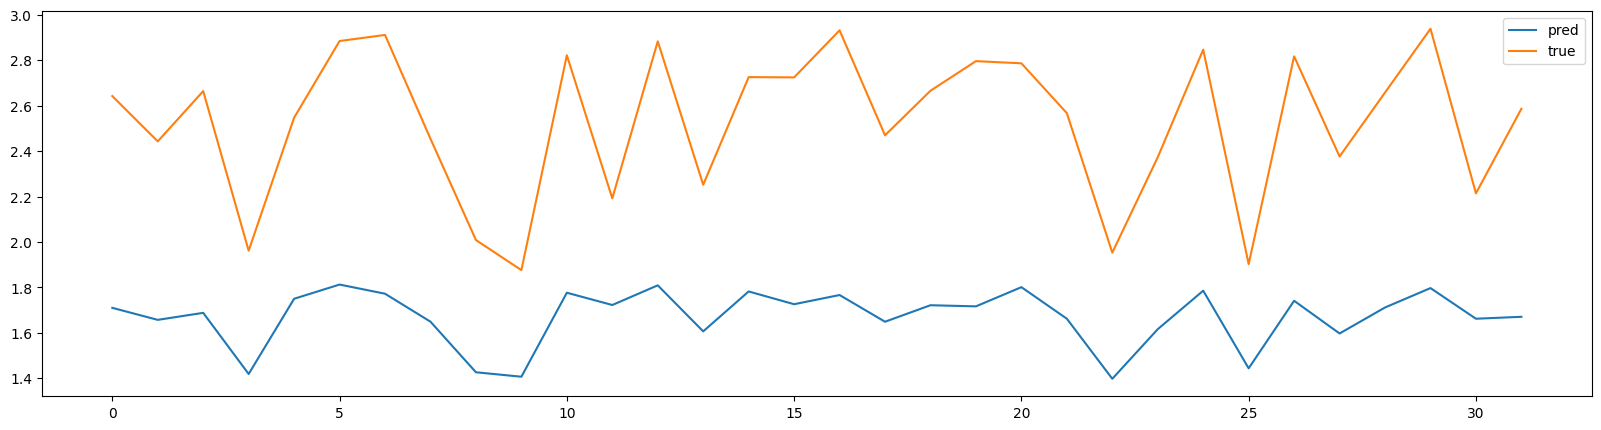

In [65]:

plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")